In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.ensemble import ExtraTreesRegressor,VotingClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn import preprocessing
import scoring as score # para hacer los reportes de puntajes
from time import time

import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

import scoring as score # para hacer los reportes de puntajes

properati = pd.read_csv('datos/properati_final.csv')

<IPython.core.display.Javascript object>

In [2]:
#paso features con strings a numericos
le_barrio = preprocessing.LabelEncoder()
barrios=properati['state_name']
le_barrio.fit(barrios)
properati['state_name'] = le_barrio.transform(barrios)

le_zona = preprocessing.LabelEncoder()
zona=properati['place_name']
le_zona.fit(zona)
properati['place_name'] = le_zona.transform(zona)

le_tipo = preprocessing.LabelEncoder()
tipos_prop=properati['property_type']
le_tipo.fit(tipos_prop)
properati['property_type'] = le_tipo.transform(tipos_prop)

In [3]:
properati.loc[:,('created_on')] = pd.to_datetime(properati['created_on'])
properati['anio'] = [x.year for x in properati['created_on'] ]
properati=properati.loc[properati.price_aprox_usd<1e7]
print len(properati)
properati=properati.groupby("place_name").filter(lambda x: len(x)>5)
print len(properati)

136353
135943


In [4]:
#preparo set de datos
X = zip(properati['surface_total_in_m2'],\
        properati['surface_covered_in_m2'],properati["property_type"],properati['state_name'],properati['place_name'])
y = properati["price_aprox_usd"]

# GBoost

In [5]:
%%notify

gb= ExtraTreesRegressor(n_jobs=-1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

n_estimators=np.arange(10,100,10)

param_grid = {"n_estimators": n_estimators}

search = RandomizedSearchCV(gb, param_distributions=param_grid ,cv=5,n_iter=2) 
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

GridSearchCV duro 35.95 segundos para 2 candidatos a hiper-parametros.

Puesto: 1
Promedio training score: 0.987 (std: 0.001)
Promedio validation score: 0.747 (std: 0.027)
Promedio fit time: 2.511s
Hiper-parametros: {'n_estimators': 80}

Puesto: 2
Promedio training score: 0.987 (std: 0.001)
Promedio validation score: 0.742 (std: 0.029)
Promedio fit time: 1.431s
Hiper-parametros: {'n_estimators': 40}



<IPython.core.display.Javascript object>

In [6]:
gboost = search.best_estimator_

# XGBoost

In [7]:
%%notify
from xgboost import XGBRegressor
xgb= XGBRegressor(nthread=-1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

learning_rate=np.arange(0.3,0.9,0.2)

param_grid = {"learning_rate": learning_rate,'min_child_weight':[1,3],'gamma':[i/10.0 for i in range(1,9)],'subsample':[i/10.0 for i in range(6,8)]}

search1 = GridSearchCV(xgb, param_grid=param_grid ,cv=5) 
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


GridSearchCV duro 30.01 segundos para 2 candidatos a hiper-parametros.

Puesto: 1
Promedio training score: 0.987 (std: 0.000)
Promedio validation score: 0.778 (std: 0.013)
Promedio fit time: 2.744s
Hiper-parametros: {'n_estimators': 80}

Puesto: 2
Promedio training score: 0.987 (std: 0.000)
Promedio validation score: 0.769 (std: 0.011)
Promedio fit time: 0.581s
Hiper-parametros: {'n_estimators': 10}



<IPython.core.display.Javascript object>

In [8]:
xgboost = search.best_estimator_

# RF

In [9]:
%%notify

rf = RandomForestRegressor(n_jobs=-1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

criterion = ['mse']
max_features =["auto","log2",None]
n_estimators = np.arange(40,100,5)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid = {"criterion": criterion,"max_features":max_features,"n_estimators":n_estimators}

search = RandomizedSearchCV(rf, param_distributions=param_grid ,cv=5,n_iter=2) #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

GridSearchCV duro 39.40 segundos para 2 candidatos a hiper-parametros.

Puesto: 1
Promedio training score: 0.959 (std: 0.002)
Promedio validation score: 0.776 (std: 0.030)
Promedio fit time: 2.549s
Hiper-parametros: {'n_estimators': 85, 'max_features': 'log2', 'criterion': 'mse'}

Puesto: 2
Promedio training score: 0.959 (std: 0.001)
Promedio validation score: 0.773 (std: 0.027)
Promedio fit time: 2.149s
Hiper-parametros: {'n_estimators': 70, 'max_features': 'log2', 'criterion': 'mse'}



<IPython.core.display.Javascript object>

In [ ]:
%%notify

rf = RandomForestClassifier(n_jobs=-1)

criterion = ['gini','entropy']
max_features =["auto","log2",None]
n_estimators = np.arange(40,100,5)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid = {"criterion": criterion,"max_features":max_features,"n_estimators":n_estimators}

search = GridSearchCV(rf, param_distributions=param_grid ,cv=5,n_iter=10) #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

In [10]:
rf= search.best_estimator_

In [9]:
search.score(X_test,y_test)

0.86392637136990325

# ETC

# MLP

In [22]:
from sklearn.neural_network import MLPRegressor

In [23]:
%%notify

mlp = MLPRegressor()

activation = ["identity", "logistic", "tanh", "relu"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid = {"activation": activation}

search = GridSearchCV(mlp, param_grid=param_grid ,cv=5,n_jobs=-1) #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

/usr/local/lib/python2.7/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV duro 804.48 segundos para 4 candidatos a hiper-parametros.

Puesto: 1
Promedio training score: 0.493 (std: 0.072)
Promedio validation score: -0.121 (std: 1.035)
Promedio fit time: 105.808s
Hiper-parametros: {'activation': 'relu'}

Puesto: 2
Promedio training score: -0.527 (std: 0.059)
Promedio validation score: -0.576 (std: 0.140)
Promedio fit time: 93.532s
Hiper-parametros: {'activation': 'tanh'}

Puesto: 3
Promedio training score: -0.528 (std: 0.059)
Promedio validation score: -0.577 (std: 0.141)
Promedio fit time: 219.882s
Hiper-parametros: {'activation': 'logistic'}

Puesto: 4
Promedio training score: 0.161 (std: 0.131)
Promedio validation score: -0.904 (std: 2.015)
Promedio fit time: 41.417s
Hiper-parametros: {'activation': 'identity'}



/usr/local/lib/python2.7/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


<IPython.core.display.Javascript object>

In [24]:
mlp=search.best_estimator_

In [61]:
search.score(X_test,y_test)

0.79543121149897333

# Lineales

In [40]:
from sklearn.linear_model import LogisticRegression

In [ ]:
%%notify

logr = LogisticRegression(n_jobs=-1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

logr.fit(X_train, y_train)
logr.score(X_test,y_test)

/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


# Ensamble

In [11]:
from mlxtend.regressor import StackingRegressor

stregr = StackingRegressor(regressors=[xgb,gboost], 
                           meta_regressor=rf)

In [12]:
%%notify
stregr.fit(X_train,y_train)

StackingRegressor(meta_regressor=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=85, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
         regressors=[XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight...stimators=80, n_jobs=-1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)],
         verbose=0)

<IPython.core.display.Javascript object>

In [13]:
stregr.score(X_test,y_test)

0.77901348475768772

In [14]:
errores = stregr.predict(X_test)-y_test
print ("Error maximo:{0}\nError minimo:{1}".format( max(abs(errores)),min(abs(errores))))
print(errores)

Error maximo:5849737.10551
Error minimo:0.0
39671       9289.091271
74578      -8832.882913
92320      45000.000000
81477         -0.011765
62534      -6879.033596
41186      18529.720028
2591        5564.023137
69850      -7291.508605
81612      26284.536294
64117     -89138.592157
80502     -49415.686275
125169     10868.860392
49791        -25.490196
110508     16896.390247
7404      -45859.983035
46405      52533.231373
15457     -10668.690760
68993     -49229.411765
102412    -29354.388235
73859      58052.567647
22997      17015.664897
125880       -62.202614
103238     -6894.135472
133694      3741.353222
87744      51602.586835
130645      9327.677141
86497      55709.266667
40701      36549.672508
35680     137141.400560
24725     185490.196078
              ...      
83643       7619.348235
34975      36480.750975
111864     49226.330532
41705       -123.529412
122023      3599.223529
109940      -545.169352
72906      -1469.954510
55867       9344.896443
49035      -1773.137

In [15]:
count_max=0
max_error=1000
lista=[]
for error in errores:
    if abs(error)>max_error:
        count_max+=1
        lista.append(abs(error))
print ("Hay {0} de {1} que tienen mas de {2} USD de error ({3}%)".format(count_max,len(errores),max_error,100 * count_max/len(errores)))

Hay 23655 de 27189 que tienen mas de 1000 USD de error (87%)


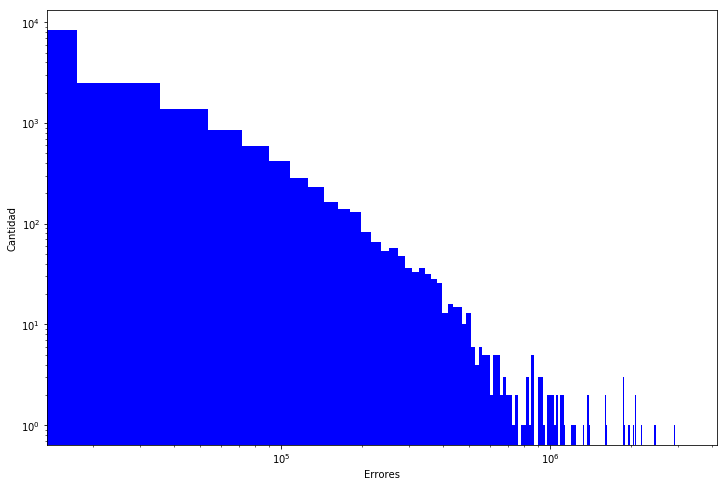

In [18]:
# the histogram of the data
plt.figure(figsize=(12,8))
plt.hist(errores, 500, facecolor='blue')
plt.xlabel('Errores')
plt.ylabel('Cantidad')
#plt.xlim(-10000000, 10000000) #para variar el "zoom a 0"
plt.yscale('log')
plt.xscale('log')
plt.show()